In [2]:
import torch
print(torch.cuda.is_available())  # должно быть True
print(torch.cuda.get_device_name(0))  # покажет название GPU (RTX 4050)


True
NVIDIA GeForce RTX 4050 Laptop GPU


In [8]:
import pandas as pd

# Загрузка файла с назначением имен колонкам
df = pd.read_csv('dataset_normalized.csv', names=[
    'Open_Time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close_Time', 'Quote_Asset_Volume', 'Number_of_Trades',
    'Taker_Buy_Volume', 'Taker_Buy_Quote_Volume'
])

# Преобразование временных меток в нормальный формат даты и времени
df['Open_Time'] = pd.to_datetime(df['Open_Time'], unit='ms')
df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit='ms')

# Просмотр первых строк
print(df.head())

            Open_Time       Open       High        Low      Close      Volume  \
0 2025-02-01 00:00:00  102429.56  102783.71  102198.52  102249.19  1810.34285   
1 2025-02-01 04:00:00  102249.19  102588.57  102118.56  102166.49  1052.21801   
2 2025-02-01 08:00:00  102166.49  102276.99  101412.00  102028.81  2029.14504   
3 2025-02-01 12:00:00  102028.82  102329.01  101730.79  102073.89  1704.67519   
4 2025-02-01 16:00:00  102073.89  102297.99  101448.00  101669.60  1472.58058   

               Close_Time  Quote_Asset_Volume  Number_of_Trades  \
0 2025-02-01 03:59:59.999        1.855825e+08            336147   
1 2025-02-01 07:59:59.999        1.077009e+08            228096   
2 2025-02-01 11:59:59.999        2.066930e+08            418187   
3 2025-02-01 15:59:59.999        1.740051e+08            385831   
4 2025-02-01 19:59:59.999        1.501242e+08            389744   

   Taker_Buy_Volume  Taker_Buy_Quote_Volume  
0         985.25105            1.010047e+08  
1         511.2589

In [1]:
import pandas as pd

df = pd.read_csv('dataset_normalized.csv', names=[
    'Open_Time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close_Time', 'Quote_Asset_Volume', 'Number_of_Trades',
    'Taker_Buy_Volume', 'Taker_Buy_Quote_Volume'
])

# рассчитываем процент изменения цены закрытия относительно следующего периода
# т.е. насколько изменится цена на следующей свече (сдвиг вверх на -1)
df['price_change_pct'] = df['Close'].pct_change().shift(-1) * 100

# определяем функцию для классификации изменения цены в target
def classify_change(change):
    if change >= 0.75:
        return 0  # рост цены >= 0.75%
    elif change <= -0.75:
        return 1  # падение цены <= -0.75%
    else:
        return 2  # нейтральное изменение

df['target'] = df['price_change_pct'].apply(classify_change)

df.dropna(subset=['price_change_pct'], inplace=True)

df.drop(columns=['price_change_pct'], inplace=True)

df.to_csv('dataset_with_target.csv', index=False)

print(df.head())



       Open_Time       Open       High        Low      Close      Volume  \
0  1738368000000  102429.56  102783.71  102198.52  102249.19  1810.34285   
1  1738382400000  102249.19  102588.57  102118.56  102166.49  1052.21801   
2  1738396800000  102166.49  102276.99  101412.00  102028.81  2029.14504   
3  1738411200000  102028.82  102329.01  101730.79  102073.89  1704.67519   
4  1738425600000  102073.89  102297.99  101448.00  101669.60  1472.58058   

      Close_Time  Quote_Asset_Volume  Number_of_Trades  Taker_Buy_Volume  \
0  1738382399999        1.855825e+08            336147         985.25105   
1  1738396799999        1.077009e+08            228096         511.25891   
2  1738411199999        2.066930e+08            418187         804.83163   
3  1738425599999        1.740051e+08            385831         854.36304   
4  1738439999999        1.501242e+08            389744         644.31801   

   Taker_Buy_Quote_Volume  target  
0            1.010047e+08       2  
1            5

In [9]:
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import pandas as pd

df = pd.read_csv('dataset_with_target.csv')

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

clf = TabNetClassifier()
clf.fit(X_train.values, y_train.values,
        eval_set=[(X_test.values, y_test.values)],
        max_epochs=100,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128)

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98833 | val_0_accuracy: 0.52407 |  0:00:01s
epoch 1  | loss: 0.89252 | val_0_accuracy: 0.52407 |  0:00:02s
epoch 2  | loss: 0.88342 | val_0_accuracy: 0.23157 |  0:00:02s
epoch 3  | loss: 0.87829 | val_0_accuracy: 0.52407 |  0:00:03s
epoch 4  | loss: 0.87435 | val_0_accuracy: 0.52407 |  0:00:03s
epoch 5  | loss: 0.87326 | val_0_accuracy: 0.52407 |  0:00:04s
epoch 6  | loss: 0.87315 | val_0_accuracy: 0.52407 |  0:00:04s
epoch 7  | loss: 0.86972 | val_0_accuracy: 0.52407 |  0:00:05s
epoch 8  | loss: 0.86983 | val_0_accuracy: 0.52407 |  0:00:06s
epoch 9  | loss: 0.87315 | val_0_accuracy: 0.52407 |  0:00:06s
epoch 10 | loss: 0.86866 | val_0_accuracy: 0.52407 |  0:00:07s
epoch 11 | loss: 0.8702  | val_0_accuracy: 0.52407 |  0:00:07s
epoch 12 | loss: 0.86888 | val_0_accuracy: 0.52407 |  0:00:08s
epoch 13 | loss: 0.8682  | val_0_accuracy: 0.52407 |  0:00:09s
epoch 14 | loss: 0.86789 | val_0_accuracy: 0.52407 |  0:00:09s
epoch 15 | loss: 0.86722 | val_0_accuracy: 0.52407 |  0

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [10]:
from sklearn.metrics import classification_report

preds = clf.predict(X_test.values)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       802
           1       0.00      0.00      0.00       760
           2       0.52      1.00      0.69      1720

    accuracy                           0.52      3282
   macro avg       0.17      0.33      0.23      3282
weighted avg       0.27      0.52      0.36      3282



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


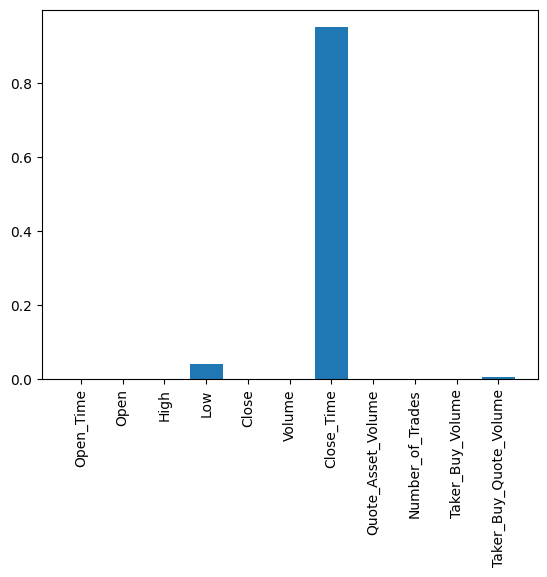

In [11]:
import matplotlib.pyplot as plt

feat_importances = clf.feature_importances_
plt.bar(X.columns, feat_importances)
plt.xticks(rotation=90)
plt.show()

In [1]:
!pip install pandas_ta

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.2.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.14.0-py3.12.egg is deprecated. pip 25.1 w

In [28]:
import pandas as pd
# import pandas_ta as ta

# [
#     'Open_Time', 'Open', 'High', 'Low', 'Close', 'Volume',
#     'Close_Time', 'Quote_Asset_Volume', 'Number_of_Trades',
#     'Taker_Buy_Volume', 'Taker_Buy_Quote_Volume'
# ]

# Загрузка датасета (предполагается, что столбец с датами называется 'datetime')
df = pd.read_csv(
    'dataset_with_target.csv',
    parse_dates=['Open_Time'],
    date_parser=lambda x: pd.to_datetime(x, unit='ms')
)
df.set_index('Open_Time', inplace=True)

df.drop('Close_Time', inplace=True, axis=1)

# Преобразуем индекс в DatetimeIndex и сортируем его
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# При необходимости зададим частоту
inferred_freq = pd.infer_freq(df.index)
if inferred_freq:
    df.index.freq = inferred_freq

# Разностные признаки для цены закрытия
for k in range(1, 6):
    df[f'close_diff_{k}'] = df['Close'].diff(k)

# EBSW (если функция есть в pandas_ta)
try:
    df['EBSW'] = ta.ebsw(df['Close'])
except Exception as e:
    print("Функция для EBSW не найдена в pandas_ta:", e)

# Chaikin Money Flow (CMF)
df['CMF'] = ta.cmf(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'])

# VWAP и отношение VWAP/Open
df['VWAP'] = ta.vwap(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'])
df['VWAP_Open_Ratio'] = df['VWAP'] / df['Open']

# Соотношения цен
df['High_Low_Ratio'] = df['High'] / df['Low']
df['High_Open_Ratio'] = df['High'] / df['Open']
df['Close_Open_Ratio'] = df['Close'] / df['Open']
df['Low_Open_Ratio'] = df['Low'] / df['Open']

# Извлечение временных признаков
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Month'] = df.index.month

print(df.head())

df.to_csv('dataset_with_indicators.csv')


/tmp/ipykernel_143/588085128.py:11: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(
/tmp/ipykernel_143/588085128.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  date_parser=lambda x: pd.to_datetime(x, unit='ms')
/tmp/ipykernel_143/588085128.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['EBSW'] = ta.ebsw(df['Close'])


                        Open     High      Low    Close      Volume  \
Open_Time                                                             
2017-08-17 08:00:00  4333.32  4485.39  4333.32  4427.30   63.619882   
2017-08-17 12:00:00  4436.06  4485.39  4333.42  4352.34  174.562001   
2017-08-17 16:00:00  4352.33  4354.84  4200.74  4325.23  225.109716   
2017-08-17 20:00:00  4307.56  4369.69  4258.56  4285.08  249.769913   
2017-08-18 00:00:00  4285.08  4340.62  4134.61  4292.39  276.193043   

                     Quote_Asset_Volume  Number_of_Trades  Taker_Buy_Volume  \
Open_Time                                                                     
2017-08-17 08:00:00        2.825012e+05               248         58.787633   
2017-08-17 12:00:00        7.742388e+05               858        125.184133   
2017-08-17 16:00:00        9.652911e+05               986        165.036363   
2017-08-17 20:00:00        1.079545e+06              1001        203.226685   
2017-08-18 00:00:00        1

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier

# Загрузим данные полностью
df = pd.read_csv('dataset_with_indicators.csv')

# Пропустим первые 40 строк
df = df.iloc[40:].reset_index(drop=True)

# Преобразуем в timestamp
df['Open_Time'] = pd.to_datetime(df['Open_Time'], format='%Y-%m-%d %H:%M:%S').astype('int64') // 10**6

# Посмотрим первые несколько строк, чтобы понять структуру
print(df.head(1))

# Разделим на признаки и целевую переменную
X = df.drop(columns=['target'])
y = df['target']

# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Обучим модель
clf = TabNetClassifier(
    device_name="cuda"
)
clf.fit(
    X_train.values, y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    max_epochs=100,
    patience=20,
    batch_size=8192,
    virtual_batch_size=4096
)

       Open_Time    Open     High      Low    Close     Volume  \
0  1503532800000  4147.0  4204.55  4085.01  4113.58  123.52015   

   Quote_Asset_Volume  Number_of_Trades  Taker_Buy_Volume  \
0        511550.36439               903         27.060743   

   Taker_Buy_Quote_Volume  ...       CMF     VWAP  VWAP_Open_Ratio  \
0           112391.452409  ...  0.046232  4134.38         0.996957   

   High_Low_Ratio  High_Open_Ratio  Close_Open_Ratio  Low_Open_Ratio  Hour  \
0        1.029263         1.013878          0.991941        0.985052     0   

   Day  Month  
0   24      8  

[1 rows x 27 columns]
epoch 0  | loss: 1.66614 | val_0_accuracy: 0.17502 |  0:00:00s


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 1.36543 | val_0_accuracy: 0.23396 |  0:00:00s
epoch 2  | loss: 1.20427 | val_0_accuracy: 0.33598 |  0:00:00s
epoch 3  | loss: 1.12205 | val_0_accuracy: 0.52932 |  0:00:00s
epoch 4  | loss: 1.06833 | val_0_accuracy: 0.57972 |  0:00:00s
epoch 5  | loss: 1.03556 | val_0_accuracy: 0.59835 |  0:00:00s
epoch 6  | loss: 1.01059 | val_0_accuracy: 0.61668 |  0:00:00s
epoch 7  | loss: 1.00011 | val_0_accuracy: 0.61118 |  0:00:00s
epoch 8  | loss: 0.99058 | val_0_accuracy: 0.60812 |  0:00:00s
epoch 9  | loss: 0.98004 | val_0_accuracy: 0.6121  |  0:00:01s
epoch 10 | loss: 0.96924 | val_0_accuracy: 0.61057 |  0:00:01s
epoch 11 | loss: 0.96655 | val_0_accuracy: 0.59377 |  0:00:01s
epoch 12 | loss: 0.96535 | val_0_accuracy: 0.55987 |  0:00:01s
epoch 13 | loss: 0.95754 | val_0_accuracy: 0.57056 |  0:00:01s
epoch 14 | loss: 0.93769 | val_0_accuracy: 0.57605 |  0:00:01s
epoch 15 | loss: 0.93672 | val_0_accuracy: 0.57819 |  0:00:01s
epoch 16 | loss: 0.9412  | val_0_accuracy: 0.47312 |  0

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [53]:
from sklearn.metrics import classification_report

preds = clf.predict(X_test.values)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.23      0.07      0.11       552
           1       0.18      0.03      0.05       484
           2       0.69      0.94      0.80      2238

    accuracy                           0.66      3274
   macro avg       0.37      0.35      0.32      3274
weighted avg       0.54      0.66      0.57      3274



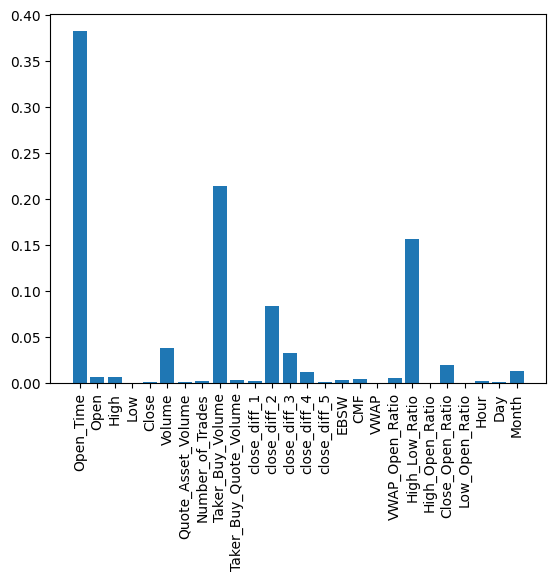

In [54]:
import matplotlib.pyplot as plt

feat_importances = clf.feature_importances_
plt.bar(X.columns, feat_importances)
plt.xticks(rotation=90)
plt.show()